### Joyce - Data Exploration, Literature Search, Features Selection

#### Notes from Dr. McAuley in Tuesday 11/26 Lecture
1. To ensure good performance on the recommender system (or predictive tasks, for this project) make sure to only extract DENSE sample of the dataset. Taking only the first 2000 rows OR randomizing data selection will likely result in finding SPARSE dataset sample. Data is not distributed evenly across the file(s). Recommender systems CANNOT use sparse sets, and it is generally recommended to choose dense dataset samples for predictive task models, as well. 
- The more dense a dataset is, the more features we can select for the model to implement, and overall make more accurate predictions.
- Define dense: high volumes of user/ item activity


2. Dr. McAuley requires an explanation for EACH data exploration step chosen, so I have included a `markdown` cell that accompanies each major exploration step to prove why XYZ step must be done. 

# Task 1: Identify a dataset, perform an exploratory analysis 

### Reviews Dataset: [UCSD Amazon Reviews 2023](https://amazon-reviews-2023.github.io/)
- **Chosen dataset:** Amazon Electronics 2023, User Reviews (ratings, text, helpfulness votes, etc.)

#### 1st Step to achieving Dr. McAuley's Criteria on obtaining ONLY dense rows: 
- Take a RANDOM sample of first 500,000 rows 7 GB dataset first, then conduct user and item density exploration. 
    - Reason: Data is NOT guaranteeed to be distributed evenly, so taking first 500,000 reviews can introduuce bia. There is no known sorting of dataset in any meaningful order (e.g., by title, timestamp, rating). 
- Read through `reviews`, count how many reviews each user and item have. 
    - Reason: To find the threshold of what it means to be "dense" or "not dense" (similar to Assignment 1's Task 1)

In [15]:
import numpy as np
import pandas as pd
import json
import gzip
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# since Amazon Electronics `review` dataset is ~ 7GB, must first split into chunks to process, then randomly extract 500,000
sample_size = 500000
chunk_size = 50000  # MEMORY-EFFICIENT, loads 5k rows at a time instead of ENTIRE 7 GB dataset

# containers to store the review counts per user and item
user_review_counts = defaultdict(int)
item_review_counts = defaultdict(int)

sampled_reviews = []

review_count = 0  # counter for total reviews processed

with gzip.open('/Users/JoyceShiah/Downloads/Electronics.jsonl.gz', 'rt', encoding='utf-8') as fp:
    chunk = []
    for line in fp:
        review = json.loads(line.strip())
    
        user_review_counts[review['user_id']] += 1  # track count of reviews per user and item
        item_review_counts[review['asin']] += 1
        
        chunk.append(review)
        
        # get the chunk, sample, and reset chunk list
        if len(chunk) >= chunk_size:
            sampled_reviews.extend(random.sample(chunk, min(chunk_size, sample_size - len(sampled_reviews))))
            review_count += len(chunk)
            
            if len(sampled_reviews) >= sample_size:
                break
            chunk = []  # clear chunk for next batch

# find total number of reviews processed in the sample
review_count = len(sampled_reviews)

# unique users & items in sampled data
unique_users = set([review['user_id'] for review in sampled_reviews])
unique_items = set([review['asin'] for review in sampled_reviews])

# BASIC STATISTICS
print(f"Total reviews processed: {review_count}")
print(f"Unique users: {len(unique_users)}")
print(f"Unique items: {len(unique_items)}")

# find distribution of review counts for users and items
user_review_distribution = sorted(user_review_counts.values(), reverse=True)
item_review_distribution = sorted(item_review_counts.values(), reverse=True)

# show basic statistics on the distribution (top 10 for both categories)
print(f"Top 10 user review counts: {user_review_distribution[:10]}")
print(f"Top 10 item review counts: {item_review_distribution[:10]}")


# 1st attempt, taking first 500k rows instead of random sampling 
# Total reviews processed: 500000
# Unique users: 94898
# Unique items: 206028
# Top 10 user review counts: [1034, 820, 764, 699, 592, 574, 563, 492, 417, 412]
# Top 10 item review counts: [5007, 1746, 1256, 1145, 864, 845, 813, 746, 573, 563]
# Conclusion: about the same results!


Total reviews processed: 500000
Unique users: 94898
Unique items: 206028
Top 10 user review counts: [1034, 820, 764, 699, 592, 574, 563, 492, 417, 412]
Top 10 item review counts: [5007, 1746, 1256, 1145, 864, 845, 813, 746, 573, 563]


#### Findings for 1st Step
**Total # of users:** 94,898 users
**Total # of items:** 206,028 items

**Top 10 users:** 412 - 1034 reviews (highest count: 1034 reviews)
- Analysis: **few very active user**, while majority of users have far fewer reviews. Most users likely have much lower activity, given that the unique users number is around 95,000.
Item Review Counts:

**Top 10 items:** 563 - 5007 reviews (most-reviewed item: 5007 reviews, which is significantly larger than the rest [outlier])
- Analysis, just like for the top 10 users, there are few popular items, while majority of items have fewer reviews.

#### 2nd Step: Testing out DENSITY Thresholds based on PERCENTILES
Adjust activity thresholds based on distribution to filter out **SPARSE** data. 
- **Choice of percentiles:** 
    - Users in the 90th percentile of reviews or more (Top 10%; common default percentile to use)
    - Items in the 80th percentile or more (Top 20%; common default percentile to use)

In [16]:
user_90th_percentile = sorted(user_review_counts.values())[(int(0.9 * len(user_review_counts)))]
item_80th_percentile = sorted(item_review_counts.values())[(int(0.8 * len(item_review_counts)))]
print(f"Top 10% of users have __ or more reviews: {user_90th_percentile}")
print(f"Top 20% of items have __ or more reviews on it: {item_80th_percentile}")

Top 10% of users have __ or more reviews: 11
Top 20% of items have __ or more reviews on it: 2


#### Findings for Step 2
Users (90th percentile) = 11 reviews
- Using threshold of 11 reviews, this will keep only the most ACTIVE (dense!) 10% of users in finalized dataset.
- The more active a user is, the more likely they are very engaged consumers for Amazon Electronics thus provide more useful data for our predictive models.

Items (80th percentile): 2 reviews
- Using threshold of 2 reviews per item, this will keep only the top 20% of items in finalized dataset.
- In our terms, items < 2 reviews = SPARSE data, not good enough to build a predictive task model. 

**Plan of action:** Filter out users < 11 created reviews + items with fewer than 2 reviews, so that our finalized dataset will only have reviews based on more well-reviewed items. 

#### 3rd Step: Test out even HIGHER Percentiles to target MOST active users, Creation of our finalized `reviews` dataset, called `filtered_reviews`

In [17]:
user_95th_percentile = np.percentile(list(user_review_counts.values()), 95)
item_95th_percentile = np.percentile(list(item_review_counts.values()), 95)

filtered_reviews = []

for review in sampled_reviews:
    # only keep reviews for users and items above the 95th percentile thresholds
    if user_review_counts[review['user_id']] >= user_95th_percentile and \
       item_review_counts[review['asin']] >= item_95th_percentile:
        filtered_reviews.append(review)
    
    # cap at 20,000 reviews
    if len(filtered_reviews) >= 20000:
        break

filtered_review_count = len(filtered_reviews)
unique_users_filtered = set(review['user_id'] for review in filtered_reviews)
unique_items_filtered = set(review['asin'] for review in filtered_reviews)

# BASIC STATS
print(f"Filtered dataset size: {filtered_review_count}")
print(f"Unique users in filtered dataset: {len(unique_users_filtered)}")
print(f"Unique items in filtered dataset: {len(unique_items_filtered)}")

# get top 10 users and items based on review counts
top_10_users = sorted(user_review_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_items = sorted(item_review_counts.items(), key=lambda x: x[1], reverse=True)[:10]

top_user_review_counts = [count for user, count in top_10_users]
top_item_review_counts = [count for item, count in top_10_items]

print("Top 10 User Review Counts:", top_user_review_counts)
print("Top 10 Item Review Counts:", top_item_review_counts)

# find user_id's and ASINs of the top 10 users and items
print("\nTop 10 Users (user_id, review_count):")
for user, count in top_10_users:
    print(f"user_id: {user}, reviews: {count}")

print("\nTop 10 Items (asin, review_count):")
for item, count in top_10_items:
    print(f"asin: {item}, reviews: {count}")

Filtered dataset size: 20000
Unique users in filtered dataset: 1626
Unique items in filtered dataset: 7334
Top 10 User Review Counts: [1034, 820, 764, 699, 592, 574, 563, 492, 417, 412]
Top 10 Item Review Counts: [5007, 1746, 1256, 1145, 864, 845, 813, 746, 573, 563]

Top 10 Users (user_id, review_count):
user_id: AEIIRIHLIYKQGI7ZOCIJTRDF5NPQ, reviews: 1034
user_id: AFTZWAK3ZHAPCNSOT5GCKQDECBTQ, reviews: 820
user_id: AECTQQX663PTF5UQ2RA5TUL3BXVQ, reviews: 764
user_id: AGUTZC4GHLTGYHA3KBEDRF6MHB6A, reviews: 699
user_id: AG73BVBKUOH22USSFJA5ZWL7AKXA, reviews: 592
user_id: AGZZXSMMS4WRHHJRBUJZI4FZDHKQ, reviews: 574
user_id: AG375WAXLZ7PIOQKIQ6KQB4J3JVQ, reviews: 563
user_id: AHDZKPPKUT7HD47LXCBN7RQNN6KQ, reviews: 492
user_id: AGBG3KK74IKWJNQVMQAGVBWJ7FAQ, reviews: 417
user_id: AGDSEYGSA5K664EUHWKV3ARDXO2Q, reviews: 412

Top 10 Items (asin, review_count):
asin: B01G8JO5F2, reviews: 5007
asin: B00ZV9RDKK, reviews: 1746
asin: B079QHML21, reviews: 1256
asin: B01DFKC2SO, reviews: 1145
asin: B0

# `final_df` Exploration starts here
- aka pandas ver of `filtered_reviews`
- Reason for turning list into Pandas dataframe `final_df`: predictive task models typically use user-item interaction matrix, so this can be easily transformed with Pandas df
    - Additionally, if using user-based or item-based collaborative filtering, we can more easily do feature extraction from a Pandas df than a list. 

In [18]:
final_df = pd.DataFrame(filtered_reviews)
print(final_df.columns)
print(final_df.iloc[0])
print(filtered_reviews[0])

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')
rating                                                             3.0
title                Nice for what it is but not as universal as I'...
text                 Unfortunately it won't control my Amazon Fire ...
images                                                              []
asin                                                        B004OVECU0
parent_asin                                                 B004OVECU0
user_id                                   AGPWEJVZ7ZM5FTZSMPQ5KSHYCIXQ
timestamp                                                1490730848000
helpful_vote                                                         4
verified_purchase                                                 True
Name: 0, dtype: object
{'rating': 3.0, 'title': "Nice for what it is but not as universal as I'd like", 'text': "Unfortunately it wo

In [19]:
print(final_df.info())
print(final_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             20000 non-null  float64
 1   title              20000 non-null  object 
 2   text               20000 non-null  object 
 3   images             20000 non-null  object 
 4   asin               20000 non-null  object 
 5   parent_asin        20000 non-null  object 
 6   user_id            20000 non-null  object 
 7   timestamp          20000 non-null  int64  
 8   helpful_vote       20000 non-null  int64  
 9   verified_purchase  20000 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 1.4+ MB
None
            rating     timestamp  helpful_vote
count  20000.00000  2.000000e+04  20000.000000
mean       4.33705  1.509531e+12      2.850550
std        1.14578  9.179225e+10     59.025704
min        1.00000  1.053358e+12      0.000000
25% 

In [20]:
# check for missing or NaN values - Perfect! No missing values
print(final_df.isnull().sum())


rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64


In [21]:
# top 10 most active users in `final_df`
top_users = final_df['user_id'].value_counts().head(10)
print("Top 10 active users in finalized dataset:")
print(top_users)

Top 10 active users in finalized dataset:
user_id
AECTQQX663PTF5UQ2RA5TUL3BXVQ    107
AG73BVBKUOH22USSFJA5ZWL7AKXA     87
AG63W2BMC4HRP76AMS36AYY64AHA     86
AHYI3O22APDQVJ3CXEJRHUYYR2BA     84
AFQNHDM5U3PICULYQWZWXFP7XHQA     80
AF4FNLSTWH3RCJD52W7TZTQOM73A     76
AENH6LSB6BM7XLPEYUL43WBOD6JA     76
AF4OCZTPFHXZKUTAGP6CAOCMWPAA     73
AE4SX2IMZGVQSS5SFWP6NEE2HQ4Q     72
AFZUK3MTBIBEDQOPAK3OATUOUKLA     72
Name: count, dtype: int64


In [22]:
# top 10 most reviewed items (ASIN)
top_items = final_df['asin'].value_counts().head(10)
print("Top 10 most reviewed (popular) items in finalized dataset:")
print(top_items)

Top 10 most reviewed (popular) items in finalized dataset:
asin
B00ZV9RDKK    95
B079QHML21    92
B01DFKC2SO    87
B01MZEEFNX    53
B00TSUGXKE    49
B07FZ8S74R    46
B0791TX5P5    44
B0043T7FXE    43
B00CX5P8FC    42
B015TJD0Y4    40
Name: count, dtype: int64


In [23]:
# find average rating by product (ASIN)
avg_ratings_per_item = final_df.groupby('asin')['rating'].mean().sort_values(ascending=False).head(10)
print("Top 10 Products by Average Rating:")
print(avg_ratings_per_item)


Top 10 Products by Average Rating:
asin
0062970704    5.0
B013TMNNDQ    5.0
B0143UM4TC    5.0
B0143HBZMW    5.0
B0140IQX6W    5.0
B013X9JBMC    5.0
B013W0ARNY    5.0
B013UJAZY8    5.0
B013TMN4GW    5.0
B0145NHF5K    5.0
Name: rating, dtype: float64


In [24]:
# find length of each review
final_df['review_length'] = final_df['text'].apply(len)
print(final_df['review_length'].describe())

count    20000.000000
mean       403.900150
std        624.234423
min          1.000000
25%         72.000000
50%        200.000000
75%        480.000000
max      15007.000000
Name: review_length, dtype: float64


In [25]:
# compare ratings of verified vs non-verified purchases
verified_vs_non_verified = final_df.groupby('verified_purchase')['rating'].mean()
print("Average Rating by Verified Purchase Status:")
print(verified_vs_non_verified)


Average Rating by Verified Purchase Status:
verified_purchase
False    4.213365
True     4.355198
Name: rating, dtype: float64


## Visualizations

#### Temporal Visualizations
- 1st visual below is **INTERACTIVE**! Please hover your mouse over each datapoint to find more information. 

In [26]:
import plotly.express as px

final_df['date'] = pd.to_datetime(final_df['timestamp'], unit='ms')

# group by month/year, count number of reviews per period
reviews_per_month = final_df.groupby(final_df['date'].dt.to_period('M')).size().reset_index(name='review_count')

reviews_per_month['date'] = reviews_per_month['date'].astype(str)

fig = px.line(
    reviews_per_month,
    x='date',
    y='review_count',
    title='Number of Reviews Over Time in Amazon Electronics Dept',
    labels={'date': 'Time (Month-Year)', 'review_count': 'Number of Reviews'},
    markers=True
)

fig.update_traces(mode='markers+lines', hovertemplate='Date: %{x}<br>Reviews: %{y}')
fig.show()

#### Time-based analysis: Analyze how ratings have changed over time
- Group by: year, month
- Aggregation by: mean

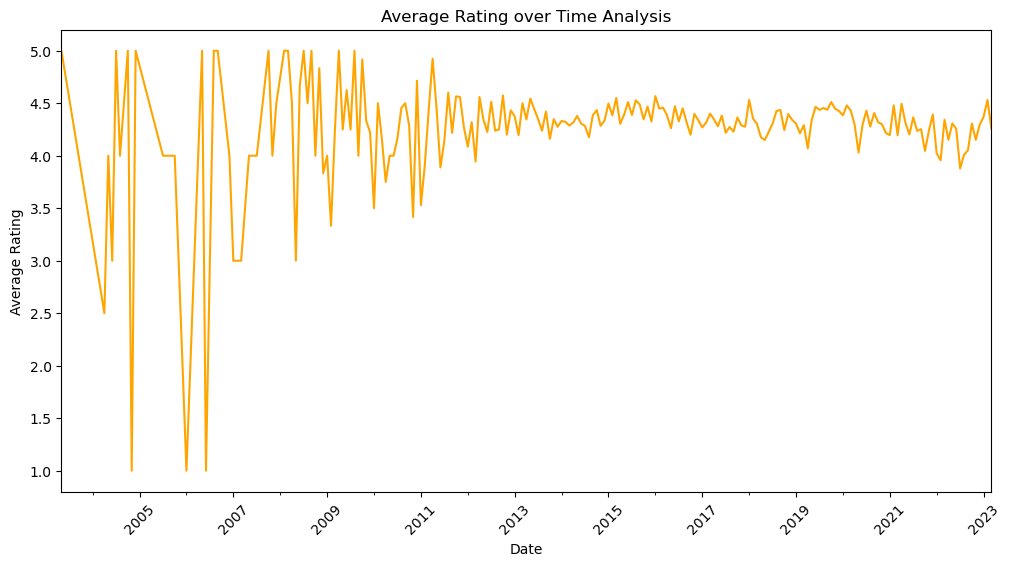

In [27]:
final_df['date'] = pd.to_datetime(final_df['timestamp'], unit='ms')

# group by year and month to find avg rating
final_df['year_month'] = final_df['date'].dt.to_period('M')
avg_ratings_over_time = final_df.groupby('year_month')['rating'].mean()

plt.figure(figsize=(12, 6))
avg_ratings_over_time.plot(kind='line', color='orange')
plt.title('Average Rating over Time Analysis')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

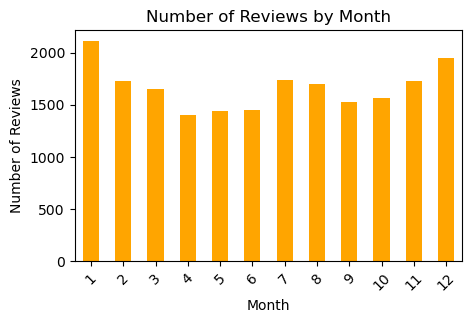

In [28]:
final_df['month'] = final_df['date'].dt.month
final_df['year'] = final_df['date'].dt.year

avg_rating_by_month = final_df.groupby('month')['rating'].mean()

# num of reviews per month
reviews_per_month = final_df.groupby('month').size()

# reviews by month: seasonal trend
plt.figure(figsize=(5, 3))
reviews_per_month.plot(kind='bar', color='orange')
plt.title('Number of Reviews by Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

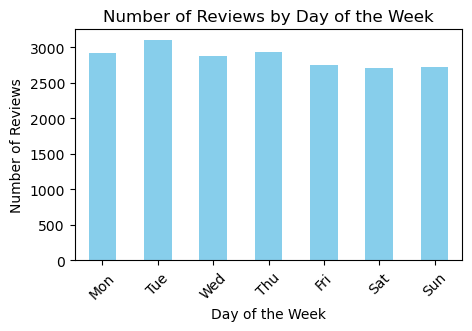

In [29]:
# 0=Monday, 6=Sunday
final_df['day_of_week'] = final_df['date'].dt.dayofweek

avg_rating_by_day = final_df.groupby('day_of_week')['rating'].mean()

reviews_per_day = final_df.groupby('day_of_week').size()

plt.figure(figsize=(5, 3))
reviews_per_day.plot(kind='bar', color='skyblue')
plt.title('Number of Reviews by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reviews')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
plt.show()

### User behavior analysis

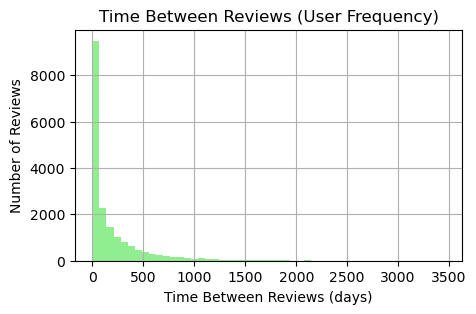

In [30]:
# Time Between Reviews for Each User (Reviewing Frequency)
# how often users review products -- frequent reviewers, post reviews intermittently?
filtered_final_df = final_df.sort_values(by=['user_id', 'date'])

# find time difference between consecutive reviews by the same user
filtered_final_df['time_diff'] = filtered_final_df.groupby('user_id')['date'].diff()

# Plot the time difference (in days) between consecutive reviews
plt.figure(figsize=(5, 3))
filtered_final_df['time_diff'].dropna().dt.days.hist(bins=50, color='lightgreen')
plt.title('Time Between Reviews (User Frequency)')
plt.xlabel('Time Between Reviews (days)')
plt.ylabel('Number of Reviews')
plt.show()


### NLP: Sentiment analysis on `text`

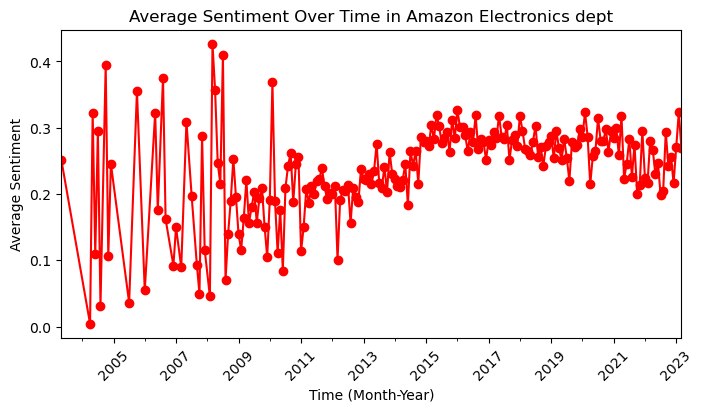

In [36]:
from textblob import TextBlob

# sentiment analysis, track how sentiment changes over time
final_df['sentiment'] = final_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)


avg_sentiment_per_month = final_df.groupby(final_df['date'].dt.to_period('M'))['sentiment'].mean()

plt.figure(figsize=(8, 4))
avg_sentiment_per_month.plot(kind='line', color='red', marker='o')
plt.title('Average Sentiment Over Time in Amazon Electronics dept')
plt.xlabel('Time (Month-Year)')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.show()


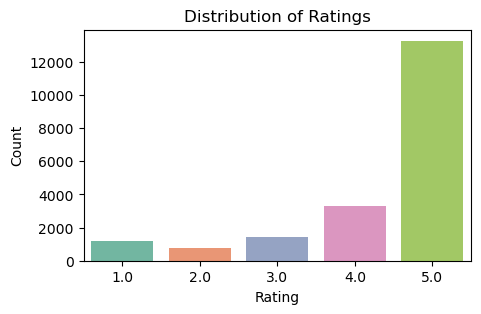

In [32]:
# reviews' rating distr
plt.figure(figsize=(5,3))
sns.countplot(x='rating', data=final_df, palette="Set2")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [33]:
final_df.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'review_length',
       'date', 'year_month', 'month', 'year', 'day_of_week', 'sentiment'],
      dtype='object')

# Task 2: Identify a predictive task

**Predictive task ideas:** 
- Idea 1: Predict an item's future rating based on temporal trends, user's review and metadata (from the `reviews` dataset)
    - As Dr. M mentioned, it's good to question things like "Does the product rating fluctuate over seasons? If the product is used in different hemispheres, will it have better ratings in one hemisphere over the other?"
    - Need to use: past `ratings`, `timestamp`'s, `verified_purchase` indicators, and most importanty USER behavior. 
    - Type of task: time series regression (predict continuous var `rating` (1 to 5) by finding correlations b/w dependent & independent vars)
- Idea 2: Predict the number of reviews of an item over time (also temporal)
- Idea 3: Predict the helpfulness of a review 
    - data on user interaction with that item, increase/ decrease of ratings over time of that specific item, stats of the review's `helpful_vote`


**Features for the Predictive Task**
- `text` (where the user writes the reviews).
- metadata for the item (`asin`) 
    - `title`, `asin`, `verified_purchase`, `timestamp` (temporal info), etc.
- `user_id`

**How to Process Features**

For `text`:
- Try vectorizing using TF-IDF or Word2Vec (NOT BERT, as there's too much fine-tuning required) to represent `text`. 
    - Function: Converse free-text data into numerical vectors.
    - **Note from Joyce:** I've worked with BERT models (specifically NER tasks), and they are very time-intensive. Due to the nature of Assignment 2 and its time constraints, I'd strongly advise against playing around with BERT. Most likely will not have time to fine-tune and obtain decent evaluation metrics.
- Preprocess `text` by removing stop words, punctuation, and lowercase everything. 
- Please refer to Dr. McAuley's [Chapter 8 Lecture Workbook](https://cseweb.ucsd.edu/~jmcauley/pml/code/chap8.html) for the pre-processing functions. 


For item's `asin`, `title`, etc. (as you see fit):
- `title`: Just as you did for `text`, vectorize `title` free-text with TF-IDF to extract features.
- `asin`: this is CATEGORICAL data, so try one-hot encoding if needed for the selected models


For temporal `timestamp`:
- Extract into Year, Month, Day, Hour, Day of Week, etc. 
- Just as I've done in the Data exploration/ Visualization sections above, you may use these features to capture seasonal effects or time-sensitive behavior trends


For `helpful_vote`: 
- I'm not sure if this is a MAIN feature to incorporate with first, but could be great if `helpful_vote` could be used to provide extra context on how an item could be rated (prediction component).


For `verified_purchase`:
- This is bascially a boolean var, so if you see more `False` pop up for Item X, that could possibly help you determine how to predict the rating for it. Likewise, if you see more `True` pop up and most ratings are decent (you'll have to set that threshold of what's considered as 'decent'), then that could also help influence the way you predict ratings for items.


### What to also account for: 
- Sean and Mengkong will need to deicde how to set the thresholds for predicting rating scores. 


### Model Selections

**[Week 9 Modeling Temporal and Sequence Data: ](https://cseweb.ucsd.edu/~jmcauley/pml/code/chap7.html)**
- Review lecture from Tuesday, 11/26 to see how to fit a temporal model for temporal predictive questions.
- Look for the code where Dr. M plots Time Series Regression models. 

**[Week 2's Linear Regression](https://cseweb.ucsd.edu/~jmcauley/pml/code/chap2.html) (Baseline model):**
- The simplest model for our predictive task, and can quicky show performance metrics with the features selected.
- Gives: Mean absolute error
- Might not be the best model, as trends for ratings generally aren't linear. There's a LOT of features that are going to be implemented, so the most basic linear regression model most likely won't product good performance. 
    - Linear regression variables are assumed to be constant over time, without any fluctuations, which is not the case here. Ratings will be affected by seasonal/ weather and social trends... and these factors most definitely fluctuate! 

**Random Forest Regressor**
- by taking account of both categorical (`asin`) and continuous features, this ensemble model will not need any scaling


### How to assess model prediction validity:
- Split `final_df` (filtered, NOT the raw reviews dataset) into training and test sets based on CHRONOLOGICAL constraints, NOT by random splits. If we use random splits, then the model will run into 'look-ahead bias.' Look-ahead bias is where the model will have data on future timestamps' data when it shouldn't be able to look that far ahead yet. So this would be a model's way of cheating and using future data to predict past timestamps' reviews/ ratings/ helpfulness for a given item. 
    - 80/20 or 70/30 should be fine. 
- Finding MAE
    - measures averaage magnitude of errors, so the lower the MAE, the better the regression model performed.
    - LOWER MAE = HIGHER ACCURACY

- Finding RMSE
    - penalizes large errors (differences are squared), can use this if we are finding LARGE errors.
    - LOWER RMSE = HIGHER ACCURACY
    - can even use MSE if preferred

# Final notes to Group B: Sean and Mengkong
Dr. McAuley emphasized during class today (11/26) that it's HIGHLY recommended to NOT use any models outside of what's been taught in class. Our peer reviewers will be doing the bulk of the grading, so it's best we use models that they are all familiar with, as well. The predictive tasks I've suggested are all within the bounds of what's been taught in DSC 256R thus far, but if any clarification is needed, please let me know. Thanks!

## Meta Dataset 
Meta dataset will NOT be analyzed, `reviews` seems much more promising to use for predictive tasks.
- Item Metadata (descriptions, price, raw image, etc.);

In [34]:
meta = []
with gzip.open('/Users/JoyceShiah/Downloads/meta_Electronics.jsonl.gz', 'rt', encoding='utf-8') as fp:
    for line in fp:
        meta.append(json.loads(line.strip()))
        if len(meta) >= 20000:
            break

In [35]:
meta[0]

{'main_category': 'All Electronics',
 'title': 'FS-1051 FATSHARK TELEPORTER V3 HEADSET',
 'average_rating': 3.5,
 'rating_number': 6,
 'features': [],
 'description': ['Teleporter V3 The “Teleporter V3” kit sets a new level of value in the FPV world with Fat Shark renowned performance and quality. The fun of FPV is experienced firsthand through the large screen FPV headset with integrated NexwaveRF receiver technology while simultaneously recording onboard HD footage with the included “PilotHD” camera. The “Teleporter V3” kit comes complete with everything you need to step into the cockpit of your FPV vehicle. We’ve included our powerful 250mW 5.8Ghz transmitter, 25 degree FOV headset (largest QVGA display available), the brand new “PilotHD” camera with live AV out and all the cables, antennas and connectors needed.'],
 'price': None,
 'images': [{'thumb': 'https://m.media-amazon.com/images/I/41qrX56lsYL._AC_US40_.jpg',
   'large': 'https://m.media-amazon.com/images/I/41qrX56lsYL._AC_.